In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from pathlib import Path

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.tree import export_graphviz

In [2]:
import fastbook
from fastbook import *
from fastai.tabular.all import *

In [3]:
def cont_cat_split(df, max_card=20, dep_var=None):
    "Helper function that returns column names of cont and cat variables from given `df`."
    cont_names, cat_names = [], []
    for column in df:
        if column in dep_var: continue
        if ((pd.api.types.is_integer_dtype(df[column].dtype) and
            df[column].unique().shape[0] > max_card) or
            pd.api.types.is_float_dtype(df[column].dtype)):
            cont_names.append(column)
        else: cat_names.append(column)
    return cont_names, cat_names

In [4]:
DATA_PATH = Path.cwd()/'Data'
RAND_STATE = 0

In [5]:
df = pd.read_csv(DATA_PATH/'Final_data.csv', low_memory=False)

#### Splitting

In [6]:
#Adding categorical age column for proportional/stratified train/test split
AGE_GROUP_AMOUNT = 8
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=AGE_GROUP_AMOUNT,
                              labels=range(AGE_GROUP_AMOUNT))

#Making train test split with proportional age groups
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1,
                             random_state=RAND_STATE)

train_idx, valid_idx = next(ss_split.split(df, df['AGE_GROUP']))
splits = (list(train_idx),list(valid_idx))

In [7]:
df['AGE'] = df["AGE"].astype(np.float32)

In [8]:
df.drop(labels=["AGE_GROUP", "SEQN"], axis=1, inplace=True, errors="ignore")

In [9]:
dep_var = 'AGE'

In [10]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [11]:
procs = [Categorify, Normalize]

In [12]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [21]:
TabularPandas

fastai.tabular.core.TabularPandas

In [23]:
torch.cuda.is_available()

False

In [42]:
size = 3,4

In [54]:
a.shape

torch.Size([2, 5, 5])

In [55]:
a = torch.randint(10, (2, 4, 5))

In [57]:
a

tensor([[[9, 4, 4, 6, 6],
         [2, 4, 3, 0, 7],
         [2, 5, 4, 9, 9],
         [9, 2, 2, 2, 9]],

        [[1, 3, 4, 2, 3],
         [2, 0, 2, 4, 1],
         [4, 2, 7, 9, 2],
         [0, 8, 0, 3, 5]]])

In [71]:
ab = torch.randint(10, (2,)).sum()

In [58]:
a[..., 1]

tensor([[4, 4, 5, 2],
        [3, 0, 2, 8]])

In [13]:
dls = to.dataloaders(512)

In [14]:
learn = tabular_learner(dls, y_range=(20, 90), n_out=1, loss_func=F.mse_loss)

/home/ja/miniconda3/envs/fastAI/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0010000000474974513)

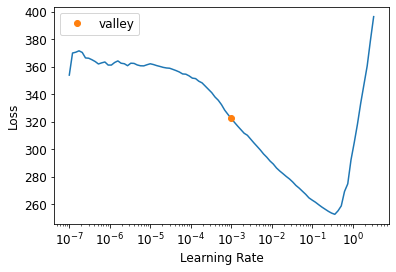

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(7, 2e-2)

epoch,train_loss,valid_loss,time
0,200.499649,171.836548,00:00
1,177.127945,165.418060,00:00
2,167.930725,156.774643,00:00
3,161.170914,155.626572,00:00
4,155.629379,154.790924,00:00
5,150.321106,152.099701,00:00
6,145.096436,150.618027,00:00


In [17]:
preds,targs = learn.get_preds()

In [18]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)
def mae(pred, y): return abs(pred - y).mean()

In [19]:
r_mse(preds,targs)

12.272654

In [20]:
mae(preds, targs)

tensor(9.6678)